# Detecting artifacts in EEG time series

In [1]:
import os
import pandas as pd
import numpy as np
import mne
import bbtools as bbt

%matplotlib notebook

In [107]:
raw = bbt.read_csv("C:/Users/jadam/OneDrive/Escritorio/Feb-8-Javi-Visedo-Activity/EEG.csv",
                   ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz'])

Creating RawArray with float64 data, n_channels=16, n_times=60712
    Range : 0 ... 60711 =      0.000 ...   237.152 secs
Ready.
DigMontage is a superset of info. 78 in DigMontage will be ignored. The ignored channels are: {'C6', 'PO7', 'PO8', 'A1', 'P9', 'TP8', 'P4', 'FT10', 'PO10', 'P3', 'PO9', 'AFz', 'FC5', 'C5', 'P10', 'F5', 'FC2', 'T3', 'FC6', 'CP6', 'PO3', 'M1', 'F6', 'T7', 'Fz', 'T9', 'FT9', 'P7', 'O9', 'FC1', 'CPz', 'AF8', 'F7', 'A2', 'AF3', 'FT7', 'Oz', 'Iz', 'T8', 'TP7', 'AF4', 'PO5', 'TP10', 'AF7', 'F9', 'T4', 'AF6', 'AF5', 'TP9', 'F10', 'F2', 'Fpz', 'FCz', 'T10', 'AF9', 'P5', 'FT8', 'P2', 'PO2', 'O10', 'PO1', 'FC4', 'FC3', 'POz', 'PO6', 'P6', 'M2', 'AF2', 'F8', 'CP5', 'PO4', 'AF1', 'F1', 'T6', 'P8', 'AF10', 'P1', 'T5'}


In [108]:
#Drop non-frontal channels
non_frontal_channels = ['C1', 'C2', 'C3', 'C4', 'CP1', 'CP2', 'CP3', 'CP4', 'O1', 'O2', 'Cz', 'Pz']
raw = raw.drop_channels(non_frontal_channels)

<IPython.core.display.Javascript object>


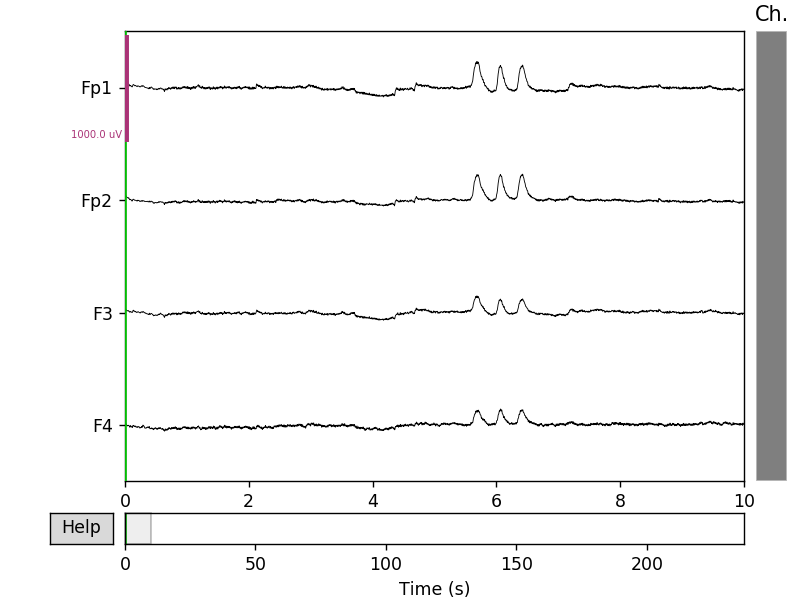

In [109]:
#Here we can look for blinks manually in order to identify when they occur
plot_fig = raw.plot(scalings=0.5e-3)


Now let's identify blinks

In [116]:
#make two datasets using moments with and without blinks
blinks=raw.copy().crop(108, 112).load_data()
no_blinks=raw.copy().crop(112, 116).load_data()

In [117]:
#now we find max, min and range values for the signal, calculated with numpy, for blinks
average_max_signal=(np.amax(blinks[0][0])+np.amax(blinks[1][0])+np.amax(blinks[2][0])+np.amax(blinks[3][0]))/4
average_min_signal=(np.amin(blinks[0][0])+np.amin(blinks[1][0])+np.amin(blinks[2][0])+np.amin(blinks[3][0]))/4
signal_range = average_max_signal-average_min_signal 
print("max = " + str(average_max_signal))
print("min = " + str(average_min_signal))
print("range = " + str(signal_range))

max = -0.00633220631324825
min = -0.00659652823325725
average = -0.006517083153482563
range = 0.00026432192000900006


In [118]:
#now we find max, min and range values for the signal, calculated with numpy, for no_blinks
average_max_signal=(np.amax(no_blinks[0][0])+np.amax(no_blinks[1][0])+np.amax(no_blinks[2][0])+np.amax(no_blinks[3][0]))/4
average_min_signal=(np.amin(no_blinks[0][0])+np.amin(no_blinks[1][0])+np.amin(no_blinks[2][0])+np.amin(no_blinks[3][0]))/4
signal_range = average_max_signal-average_min_signal 
print("max = " + str(average_max_signal))
print("min = " + str(average_min_signal))
print("range = " + str(signal_range))

max = -0.006387027871284048
min = -0.006569567659021799
average = -0.006498696626942153
range = 0.0001825397877377507


In [119]:
#now we find average and peak values, plus others, calculated with numpy, for full dataset
#signal_average=(np.average(raw[0][0])+np.average(raw[1][0])+np.average(raw[2][0])+np.average(raw[3][0]))/4
average_max_signal=(np.amax(raw[0][0])+np.amax(raw[1][0])+np.amax(raw[2][0])+np.amax(raw[3][0]))/4
average_min_signal=(np.amin(raw[0][0])+np.amin(raw[1][0])+np.amin(raw[2][0])+np.amin(raw[3][0]))/4
signal_range = average_max_signal-average_min_signal 
#middle_signal=(average_max_signal+average_min_signal)/2
print("max = " + str(average_max_signal))
print("min = " + str(average_min_signal))
print("average = " + str(signal_average))

max = 0.0012620395983239507
min = -0.007543610041243551
average = -0.00559543518589975
range = 0.008805649639567502


We can see that blinks tend to have a range around 0.00026, while parts with no blinks have values of less than 0.0002, and the overall dataset has an overall range of 0.0088

We are going to establish that a given epoch will have a blink if its signal range is within the limits typical for blinks

In [153]:
#let's test here for specific code fragments and see if it would be a blink
test=raw.copy().crop(4, 8).load_data()
average_max_signal=(np.amax(test[0][0])+np.amax(test[1][0])+np.amax(test[2][0])+np.amax(test[3][0]))/4
average_min_signal=(np.amin(test[0][0])+np.amin(test[1][0])+np.amin(test[2][0])+np.amin(test[3][0]))/4
signal_range = average_max_signal-average_min_signal 
print("range = " + str(signal_range))

range = 0.00028365943218485075


In [154]:
# if the signal range is between the values below we will consider this a blink and send a blink signal to the game 
if (signal_range >= 0.0002 and signal_range <= 0.00033):
    print ("blink")

blink
